First, load the data,in this notebook we are using the PMI data from the paper:"Environmental predictors impact microbialbased postmortem interval (PMI) estimation models within human decomposition soils". The preprocessed data includes OTU/phylum/class/order abundance matrices (includes or not include environmental factors).

This analysis is mainly for the final project of EPP622, and the analysis is different from the previous file in these ways:

1. the data preprocessing is different, previously we "we only consider OTU/ASVs that make up $\ge 1\%$ of the total microbiome community as ``present''", here we will change the threshold to $0.1\%$ based on the paper.

2. To make it simple, only use 16S data and do not consider environmental data.

In [1]:
import sys
sys.path.append('../../../Code')
import loadData 
import RunML
import RunML_continue
import FS
import metric



2025-01-27 00:54:09.444675: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-27 00:54:09.447033: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-27 00:54:09.450452: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-27 00:54:09.460026: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737957249.475950 3846144 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737957249.48

In [2]:
import pandas as pd
import numpy as np
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
import pickle
import matplotlib.pyplot as plt
import glob
import os

In [3]:
PMIdata_path = '../data/count_table/'

## No env model
16s (OTU/phylum/class/order) - no env

### Data preprocess


In [4]:
bact_noenv_files = glob.glob(PMIdata_path + 'bact.n.*.noenv.csv')


In [5]:
bact_noenv_files

['../data/count_table/bact.n.otu.noenv.csv',
 '../data/count_table/bact.n.order.noenv.csv',
 '../data/count_table/bact.n.class.noenv.csv',
 '../data/count_table/bact.n.phylum.noenv.csv']

In [26]:
# Read each CSV file into a list of dataframes
bact_noenv_df_list = [pd.read_csv(file) for file in bact_noenv_files]

In [27]:
bact_noenv_df_list[3]

,ADH_10_actual,Proteobacteria,Verrucomicrobia,Acidobacteria,Actinobacteria,Firmicutes,Bacteroidetes,Chloroflexi,Rokubacteria,Entotheonellaeota,Nitrospirae,Fusobacteria,Planctomycetes,Bacteria_unclassified,Gemmatimonadetes,Latescibacteria,Epsilonbacteraeota,Dependentiae,Cyanobacteria,Elusimicrobia,BRC1,Armatimonadetes,Patescibacteria,Chlamydiae,WPS-2,WS2,FBP,Fibrobacteres,Hydrogenedentes,Spirochaetes,Tenericutes,Deinococcus-Thermus,Omnitrophicaeota,FCPU426,WS4,Kiritimatiellaeota
0,0.00000,2405.899397,957.553453,1988.986693,2524.409168,92.418396,311.448621,526.359155,123.316076,99.009901,74.429080,0.000000,498.345258,111.368973,146.935637,36.115956,0.000000,3.433076,8.239381,15.654825,2.746460,27.052636,29.524450,3.845045,1.785199,1.785199,1.647876,3.158430,0.686615,0.000000,0.000000,0.000000,2.883784,0.686615,0.000000,0.137323
1,1484.14700,3209.276660,757.215776,1727.647573,1840.003679,226.398320,680.881068,465.059244,117.874278,67.904168,57.327672,0.000000,443.906252,109.443738,145.158571,68.364015,0.000000,2.145956,7.204280,15.021689,1.379543,24.525207,20.386579,5.211607,1.686108,1.226260,0.459848,1.379543,0.459848,0.153283,0.000000,0.000000,1.532825,0.306565,0.000000,0.000000
2,1989.56009,3829.070365,412.942989,821.982537,1300.667694,389.111454,2416.230098,276.938880,48.073960,41.088855,35.130971,0.000000,240.780688,56.291731,66.769389,19.517206,2.876220,0.205444,4.519774,4.519774,0.821777,13.970211,11.504879,3.081664,1.643554,0.000000,0.000000,0.410889,0.616333,0.000000,0.000000,0.000000,0.616333,0.000000,0.000000,0.410889
3,2973.68000,3194.403374,419.280034,848.987596,1688.948376,1069.522046,1868.083981,287.613030,65.055328,42.488288,29.570604,0.000000,303.487775,58.518668,57.584860,13.540224,1.711982,0.622539,6.069755,4.824677,1.867617,15.407841,11.050068,3.735234,2.490156,0.933809,0.622539,2.023252,0.466904,0.000000,0.000000,0.466904,0.311270,0.000000,0.155635,0.000000
4,4027.69203,3694.823154,475.772750,833.851140,1209.230357,465.538458,2514.224448,230.271574,60.065548,51.049624,33.505123,0.000000,234.048515,59.334527,62.989632,16.691643,2.193063,1.705715,6.944698,3.045920,1.462042,14.011233,19.859400,3.411431,0.000000,0.243674,0.731021,0.852858,2.436736,0.000000,0.609184,0.000000,0.487347,0.000000,0.121837,0.000000
5,0.00000,2856.727316,510.240928,2190.515356,2044.975827,129.089851,683.464061,705.229794,4.714237,39.218440,34.905414,0.000000,487.371863,83.652631,135.609541,33.701779,0.000000,6.419387,7.823627,11.033321,9.227868,6.018175,1.705150,12.537864,0.100303,0.501515,0.401212,1.504544,1.705150,0.000000,0.401212,0.300909,0.401212,0.100303,0.100303,0.000000
6,1026.39400,3528.146516,394.431822,1965.988905,1571.614749,274.026319,740.770641,634.723840,36.790571,37.309560,60.894737,0.000000,423.725881,80.904656,132.803580,57.607806,0.000000,5.305223,5.651216,10.610447,7.150518,8.707486,2.767943,14.531699,0.000000,0.980313,0.057665,0.864982,0.980313,0.057665,0.980313,0.000000,0.057665,0.403658,0.922648,0.000000
7,1423.47300,3714.381398,350.835044,1530.234861,1519.168887,231.657421,1324.567917,544.853594,22.350355,28.028946,39.240525,0.145605,370.564510,79.354679,120.196858,67.560681,2.548086,5.896999,4.732160,11.065974,4.732160,6.261011,4.222543,12.230813,0.000000,1.383247,0.291210,1.164839,0.218407,0.072802,0.291210,0.000000,0.291210,0.145605,0.291210,0.873629
8,214.93800,2950.186377,481.192816,2134.530668,1796.340224,144.357845,514.740766,837.004405,33.886818,65.062691,71.501186,0.000000,529.312098,112.504236,165.028804,80.311759,0.000000,3.727550,17.621145,14.910200,3.727550,16.943409,5.421891,16.943409,0.000000,0.000000,0.000000,1.016605,0.000000,0.677736,0.677736,0.000000,0.338868,1.016605,1.016605,0.000000
9,493.69600,2774.533715,479.592766,2230.981753,1879.408580,128.120794,723.487800,772.671612,20.139051,36.432453,52.422252,0.000000,506.411100,87.134284,177.405807,61.530365,0.000000,5.768472,6.375679,9.006912,7.893698,10.120126,4.149252,18.216227,0.000000,0.910811,0.607208,2.327629,0.910811,0.202403,0.303604,0.00

In [28]:
# target variable
y = bact_noenv_df_list[3].iloc[:, 0].values 
y

array([   0.     , 1484.147  , 1989.56009, 2973.68   , 4027.69203,
          0.     , 1026.394  , 1423.473  ,  214.938  ,  493.696  ,
          0.     , 1543.201  , 2970.8    , 3542.968  ,    0.     ,
       1445.51502, 2962.59226, 3504.55394, 4583.2796 ,    0.     ,
       2639.949  , 3573.444  ,    0.     , 1507.78   , 3103.803  ,
       4567.716  ,    0.     , 1510.142  , 2847.791  , 4578.995  ,
          0.     , 1589.377  , 3031.373  , 4512.836  ,    0.     ,
       1502.226  , 3019.923  , 4574.528  ,    0.     , 1364.604  ,
       3009.054  , 3407.734  ,    0.     , 1530.639  , 2949.689  ,
       4391.578  ,    0.     , 1588.226  , 3011.635  , 3976.49   ,
          0.     , 1445.393  , 2999.732  , 4527.275  ,    0.     ,
       1532.17172, 3552.96112, 4474.30808,    0.     , 1329.627  ,
       2854.888  , 4326.392  ,    0.     , 1600.15   , 3024.861  ,
       3985.61   ,    0.     , 1087.43   , 1533.552  ,  510.076  ,
          0.     , 1500.02566, 2988.04838, 4447.32241,    0.  

In [29]:
col_names_4taxa= []
for i in range(len(bact_noenv_df_list)):
    bact_noenv_df_list[i] = bact_noenv_df_list[i].drop(bact_noenv_df_list[i].columns[0], axis=1)
    cols_name = bact_noenv_df_list[i].columns
    col_names_4taxa.append(cols_name)

for df in bact_noenv_df_list:
    print(df.shape)

(78, 5195)
(78, 264)
(78, 111)
(78, 35)


In [10]:
bact_noenv_df_list[3]

,Proteobacteria,Verrucomicrobia,Acidobacteria,Actinobacteria,Firmicutes,Bacteroidetes,Chloroflexi,Rokubacteria,Entotheonellaeota,Nitrospirae,...,FBP,Fibrobacteres,Hydrogenedentes,Spirochaetes,Tenericutes,Deinococcus-Thermus,Omnitrophicaeota,FCPU426,WS4,Kiritimatiellaeota
0,2405.899397,957.553453,1988.986693,2524.409168,92.418396,311.448621,526.359155,123.316076,99.009901,74.429080,...,1.647876,3.158430,0.686615,0.000000,0.000000,0.000000,2.883784,0.686615,0.000000,0.137323
1,3209.276660,757.215776,1727.647573,1840.003679,226.398320,680.881068,465.059244,117.874278,67.904168,57.327672,...,0.459848,1.379543,0.459848,0.153283,0.000000,0.000000,1.532825,0.306565,0.000000,0.000000
2,3829.070365,412.942989,821.982537,1300.667694,389.111454,2416.230098,276.938880,48.073960,41.088855,35.130971,...,0.000000,0.410889,0.616333,0.000000,0.000000,0.000000,0.616333,0.000000,0.000000,0.410889
3,3194.403374,419.280034,848.987596,1688.948376,1069.522046,1868.083981,287.613030,65.055328,42.488288,29.570604,...,0.622539,2.023252,0.466904,0.000000,0.000000,0.466904,0.311270,0.000000,0.155635,0.000000
4,3694.823154,475.772750,833.851140,1209.230357,465.538458,2514.224448,230.271574,60.065548,51.049624,33.505123,...,0.731021,0.852858,2.436736,0.000000,0.609184,0.000000,0.487347,0.000000,0.121837,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,2456.386357,702.629879,1096.355563,2612.831828,1416.120207,209.098033,519.102019,161.669485,29.144499,24.882803,...,0.000000,2.474533,0.000000,0.000000,0.000000,0.000000,0.137474,0.000000,0.000000,0.000000
74,2919.908680,1004.519405,1906.070913,954.200252,28.421004,1003.432263,630.853096,87.437295,19.413254,60.724658,...,1.553060,3.882651,1.863672,1.397754,0.155306,0.000000,4.193263,0.155306,0.621224,1.087142
75,4411.744255,735.145847,1127.142509,1262.559538,178.006467,886.381810,434.238431,128.985155,45.718458,27.465842,...,0.000000,0.347669,0.173834,0.347669,0.000000,0.173834,0.869172,0.173834,0.521503,0.347669
76,2821.384741,962.492330,1377.965842,1773.368787,586.137247,543.055840,570.541010,179.740233,65.964410,41.803027,...,0.511352,0.639190,0.894866,0.000000,0.255676,0.000000,0.767028,0.000000,0.127838,0.383514


In [11]:
# Define the threshold
y_threshold = 2500

# Categorize the series based on the threshold
y = np.where(y > y_threshold, 'LONG', 'SHORT')

print(y)

['SHORT' 'SHORT' 'SHORT' 'LONG' 'LONG' 'SHORT' 'SHORT' 'SHORT' 'SHORT'
 'SHORT' 'SHORT' 'SHORT' 'LONG' 'LONG' 'SHORT' 'SHORT' 'LONG' 'LONG'
 'LONG' 'SHORT' 'LONG' 'LONG' 'SHORT' 'SHORT' 'LONG' 'LONG' 'SHORT'
 'SHORT' 'LONG' 'LONG' 'SHORT' 'SHORT' 'LONG' 'LONG' 'SHORT' 'SHORT'
 'LONG' 'LONG' 'SHORT' 'SHORT' 'LONG' 'LONG' 'SHORT' 'SHORT' 'LONG' 'LONG'
 'SHORT' 'SHORT' 'LONG' 'LONG' 'SHORT' 'SHORT' 'LONG' 'LONG' 'SHORT'
 'SHORT' 'LONG' 'LONG' 'SHORT' 'SHORT' 'LONG' 'LONG' 'SHORT' 'SHORT'
 'LONG' 'LONG' 'SHORT' 'SHORT' 'SHORT' 'SHORT' 'SHORT' 'SHORT' 'LONG'
 'LONG' 'SHORT' 'SHORT' 'LONG' 'LONG']


In [12]:
list(y).count('LONG')

35

In [13]:
list(y).count('SHORT')

43

##### 1. calculate H statistics for OTU/phylum/class/order (16s)

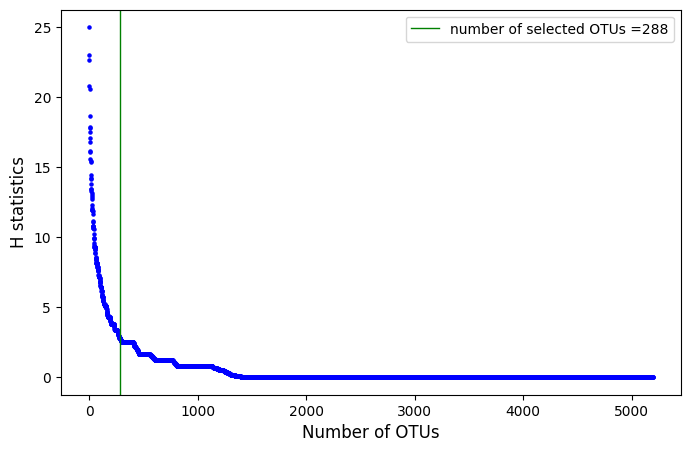

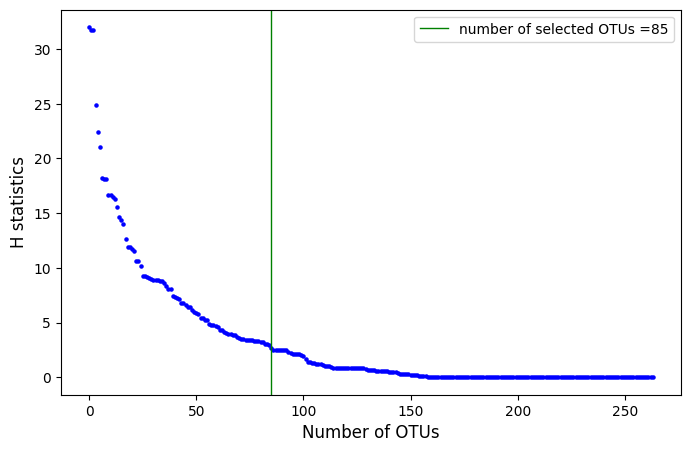

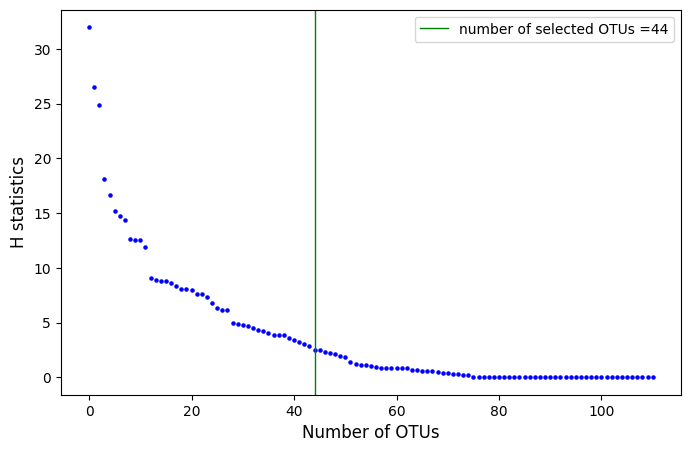

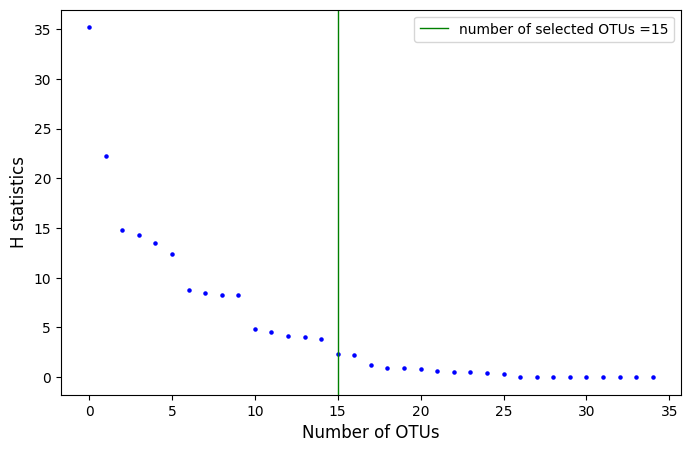

In [14]:
data_4taxa = []
weights_4taxa = []
selectedOTU_index_4tax = []
X_FS_4taxa = []
selectedASVs_4taxa = []

for df in bact_noenv_df_list:
    select_result = FS.SelectMicro_fun(df,y,threshold=0.001)
    data_4taxa.append(select_result['relative_abundance_data'])
    weights_4taxa.append(select_result['H_score'])
    selectedOTU_index_4tax.append(select_result['selected_indices'])
    X_FS_4taxa.append(select_result['selected_data'])
    selectedASVs_4taxa.append(select_result['selected_columnames'])
    

In [15]:
data_4taxa[0]

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.02616414, 0.00130018, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00235105, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.00304625, 0.1548722 , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.01834826, 0.01637905, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00712766, 0.0403091 , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [16]:
max(weights_4taxa[3])

35.19309474746626

#### 4. Model
Prepare 4 datasets: full dataset, our selected dataset, Lasso selected  dataset(based on the target variable), randomly selected data (selected the same numer of variables as in our method)

Use random forest and SVM as classifier, and will build both models for each response variable.

For Lasso, the dataset will be determined by the response variable, so the lasso subset is different for the models for different response variables.

For random selection, the  process will repeat iter=30 times to  find the mean accuracy and AUC

SMOTE  is used (the data is not balanced, as we can see the performance is really bad especially for SVM model when not using SMOTE)

In [17]:
iter =30
cls = ["RF","SVM", "CatBoost","NB"]

In [18]:
targetLabel=y

In [19]:
data_subset_4taxa = []
X_lasso_4taxa = []
xind_lasso_4taxa = []

X_FS_lasso_4taxa = []
xind_FS_lasso_4taxa = []

for i, data  in enumerate(data_4taxa):

    X_FS = X_FS_4taxa[i]
    
    X_lasso_ft,xlabel_lasso_ft  = RunML_continue.LassoFS_CV(data,targetLabel)
    X_lasso_4taxa.append(X_lasso_ft)
    xind_lasso_4taxa.append(xlabel_lasso_ft)

    X_FS_lasso_ft,xlabel_FS_lasso_ft0  = RunML_continue.LassoFS_CV(X_FS,targetLabel)
    xlabel_FS_lasso_ft = selectedOTU_index_4tax[i][xlabel_FS_lasso_ft0]
    X_FS_lasso_4taxa.append(X_FS_lasso_ft)
    xind_FS_lasso_4taxa.append(xlabel_FS_lasso_ft)
    
    data_subset = {"AllFeatures":data, 
               "SelectMicro": X_FS,
               "Lasso_finetune":X_lasso_ft,
               "FS_Lassofinetune":X_FS_lasso_ft,
               
              }
    data_subset_4taxa.append(data_subset)

Best alpha: 0.1
Best alpha: 0.05
Best alpha: 0.1
Best alpha: 0.05


/lustre/isaac/scratch/mhe8/myenv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.552e-03, tolerance: 1.510e-03
  model = cd_fast.enet_coordinate_descent(


Best alpha: 0.05
Best alpha: 0.01
Best alpha: 0.05
Best alpha: 0.05


In [20]:
for dataset  in data_subset_4taxa:
    for datatype, subset in dataset.items():
        print(np.shape(subset))

(78, 5195)
(78, 288)
(78, 15)
(78, 28)
(78, 264)
(78, 85)
(78, 9)
(78, 12)
(78, 111)
(78, 44)
(78, 14)
(78, 22)
(78, 35)
(78, 15)
(78, 6)
(78, 6)


In [21]:
#with open('../data/subset_bact_4taxa_noenv_update.pkl', 'wb') as file:
#   pickle.dump(data_subset_4taxa, file)


The  function will print out the accuracy and AUC for each dataset using each classifier, and also will return the y_actual, y_predict, y_predprob for future use.

In [22]:
taxlabels = ['OTU', 'order', 'class', 'phylum']
dict_cm_list = []

In [23]:
for i , dataset  in enumerate(data_subset_4taxa):
    print(f"Analysis for {taxlabels[i]}")
    dict_cm = RunML_continue.runClassifier_FScompare(data_subsets= dataset,y= targetLabel,classifiers=cls)
    print(metric.metric_sum(dict_cm))
    dict_cm_list.append(dict_cm)

Analysis for OTU
Classes: ['LONG' 'SHORT']
[0.8174603174603174, 0.9841269841269842, 0.6428571428571429, 0.9732142857142858, 0.8482142857142857]
[0.746031746031746, 0.9206349206349206, 0.7936507936507937, 1.0, 0.9107142857142858]


TBB Warning: The number of workers is currently limited to 0. The request for 47 workers is ignored. Further requests for more workers will be silently ignored until the limit changes.



[0.9206349206349207, 1.0, 0.6349206349206349, 1.0, 0.8571428571428571]
[0.5634920634920635, 0.7857142857142857, 0.7619047619047619, 0.9375, 0.9375]
[0.873015873015873, 1.0, 0.6111111111111112, 0.9910714285714286, 0.875]
[0.7777777777777778, 0.9523809523809523, 0.8412698412698413, 0.9642857142857143, 0.8928571428571429]
[0.8888888888888888, 1.0, 0.6507936507936507, 1.0, 0.8392857142857143]
[0.7301587301587301, 0.873015873015873, 0.753968253968254, 0.9375, 0.9285714285714286]
[0.9920634920634921, 1.0, 0.8888888888888888, 0.9821428571428572, 0.9821428571428572]
[0.9365079365079365, 1.0, 0.7936507936507936, 1.0, 0.8928571428571428]
[0.9365079365079365, 1.0, 0.7619047619047619, 0.9642857142857143, 0.9821428571428572]
[0.9285714285714285, 1.0, 0.8968253968253969, 1.0, 0.9821428571428571]
[0.9682539682539683, 1.0, 0.8333333333333333, 1.0, 0.9107142857142857]
[0.9841269841269842, 1.0, 0.7936507936507937, 1.0, 0.9107142857142858]
[0.9523809523809523, 1.0, 0.7936507936507936, 0.9821428571428572,

In [24]:
dict_cm2_list = []
for i , dataset  in enumerate(data_subset_4taxa):
    print(f"Analysis for {taxlabels[i]}")
    dict_cm = RunML_continue.runClassifier_FScompare(data_subsets= dataset,y= targetLabel,classifiers=['xgboost'])
    print(metric.metric_sum(dict_cm))
    dict_cm2_list.append(dict_cm)

Analysis for OTU
Classes: ['LONG' 'SHORT']
[0.7777777777777778, 0.9682539682539684, 0.6190476190476191, 0.9464285714285714, 0.7857142857142857]
[0.8253968253968254, 1.0, 0.6825396825396826, 1.0, 0.8214285714285715]
[0.9682539682539683, 0.9841269841269842, 0.7142857142857143, 0.9464285714285714, 0.9642857142857143]
[0.9682539682539683, 0.9682539682539684, 0.7142857142857143, 0.9285714285714286, 0.9642857142857143]
                  xgboost_Accuracy  xgboost_AUC  xgboost_Accuracy_std  \
AllFeatures           0.745833       0.819444          0.128398         
SelectMicro           0.810833       0.865873          0.184872         
Lasso_finetune        0.821667       0.915476          0.070681         
FS_Lassofinetune      0.822500       0.908730          0.105922         

                  xgboost_AUC_std  xgboost_mcc  xgboost_F  
AllFeatures          0.127516       0.504825    0.755602   
SelectMicro          0.121000       0.640566    0.803736   
Lasso_finetune       0.101308       0

### compare the first 15 index by their present ratio

Analysis for OTU
Validation passed: Dimensions are correct.
Long= 35, short = 43
      OTU     presence_pos  presence_neg
0   Otu00009    0.257143      0.790698  
1   Otu00003    0.142857      0.000000  
2   Otu00008    0.285714      0.000000  
3   Otu00001    0.285714      0.093023  
4   Otu00150    0.000000      0.000000  
5   Otu00012    0.057143      0.000000  
6   Otu00129    0.000000      0.000000  
7   Otu00021    0.028571      0.000000  
8   Otu00273    0.000000      0.000000  
9   Otu00036    0.114286      0.000000  
10  Otu00015    0.171429      0.023256  
11  Otu00037    0.228571      0.046512  
12  Otu00010    0.171429      0.023256  
13  Otu00174    0.000000      0.000000  
14  Otu00096    0.028571      0.000000  


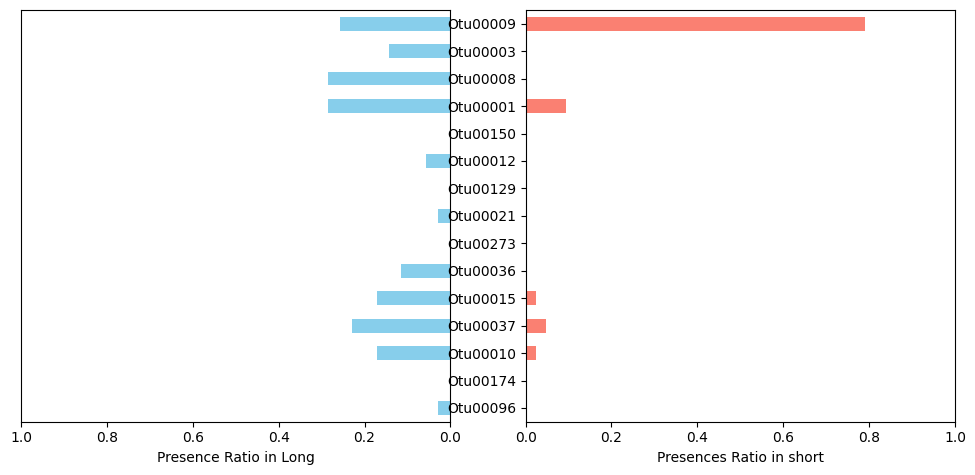

Validation passed: Dimensions are correct.
Long= 35, short = 43
      OTU     presence_pos  presence_neg
0   Otu00008    0.285714      0.000000  
1   Otu00009    0.257143      0.790698  
2   Otu00037    0.228571      0.046512  
3   Otu00081    0.057143      0.000000  
4   Otu00106    0.085714      0.000000  
5   Otu00136    0.028571      0.000000  
6   Otu00151    0.000000      0.000000  
7   Otu00207    0.000000      0.000000  
8   Otu00227    0.000000      0.000000  
9   Otu00273    0.000000      0.000000  
10  Otu00277    0.000000      0.000000  
11  Otu00322    0.000000      0.000000  
12  Otu00419    0.000000      0.000000  
13  Otu00560    0.000000      0.000000  
14  Otu00602    0.000000      0.000000  


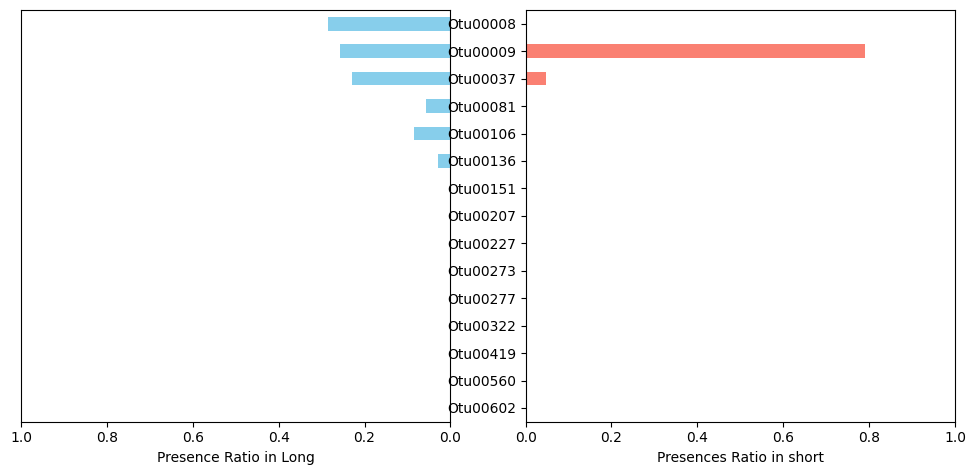

Validation passed: Dimensions are correct.
Long= 35, short = 43
      OTU     presence_pos  presence_neg
0   Otu00009    0.257143      0.790698  
1   Otu00008    0.285714      0.000000  
2   Otu00273    0.000000      0.000000  
3   Otu00015    0.171429      0.023256  
4   Otu00037    0.228571      0.046512  
5   Otu00207    0.000000      0.000000  
6   Otu00106    0.085714      0.000000  
7   Otu00227    0.000000      0.000000  
8   Otu00361    0.000000      0.000000  
9   Otu00136    0.028571      0.000000  
10  Otu00151    0.000000      0.000000  
11  Otu00560    0.000000      0.000000  
12  Otu00602    0.000000      0.000000  
13  Otu00081    0.057143      0.000000  
14  Otu00277    0.000000      0.000000  


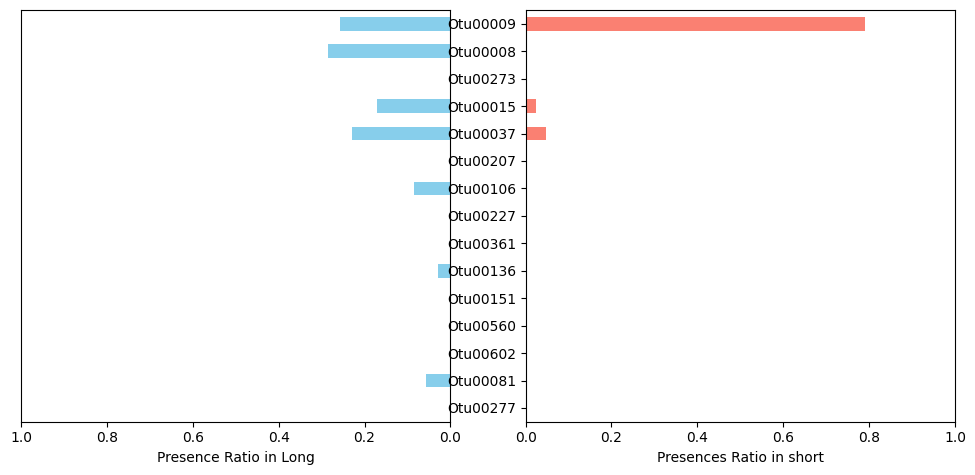

Analysis for order
Validation passed: Dimensions are correct.
Long= 35, short = 43
            OTU            presence_pos  presence_neg
0           Clostridiales    0.857143      0.325581  
1           Bacteroidales    0.228571      0.000000  
2         Lactobacillales    0.314286      0.046512  
3         Selenomonadales    0.228571      0.000000  
4    Bacilli_unclassified    0.257143      0.000000  
5       Cardiobacteriales    0.314286      0.093023  
6              Bacillales    0.771429      0.372093  
7   Thermoanaerobaculales    0.000000      0.000000  
8          Pedosphaerales    0.314286      0.767442  
9           Subgroup_6_or    0.942857      1.000000  
10      Enterobacteriales    0.285714      0.116279  
11       Blastocatellales    0.114286      0.302326  
12        Chitinophagales    0.742857      0.976744  
13           Cytophagales    0.057143      0.348837  
14  Bacteria_unclassified    0.057143      0.279070  


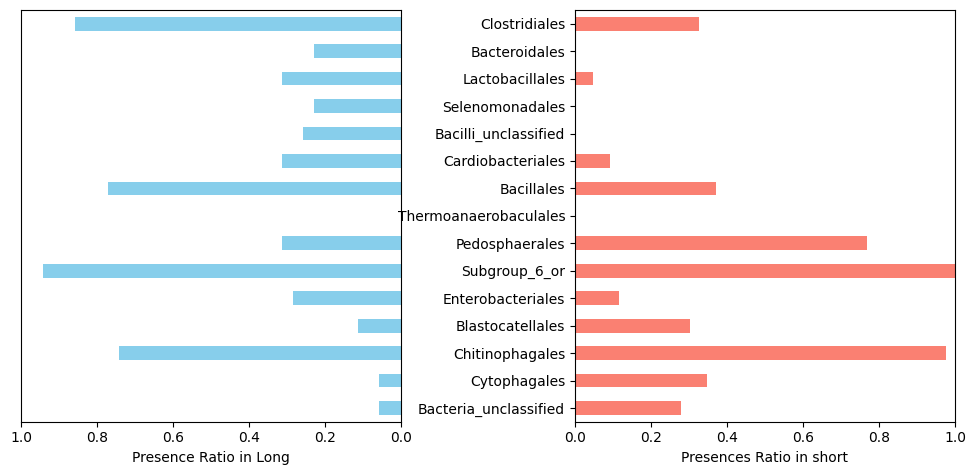

Validation passed: Dimensions are correct.
Long= 35, short = 43
           OTU            presence_pos  presence_neg
0          Clostridiales    0.857143      0.325581  
1   Bacilli_unclassified    0.257143      0.000000  
2      Corynebacteriales    0.857143      0.558140  
3        Selenomonadales    0.228571      0.000000  
4        Chitinophagales    0.742857      0.976744  
5         Pedosphaerales    0.314286      0.767442  
6          Bacteroidales    0.228571      0.000000  
7             Subgroup_7    0.000000      0.023256  
8  Thermoanaerobaculales    0.000000      0.000000  


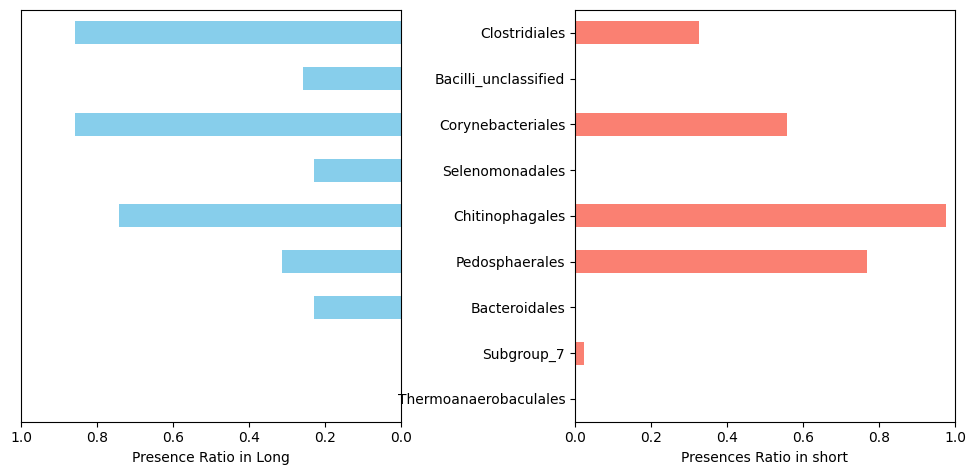

Validation passed: Dimensions are correct.
Long= 35, short = 43
            OTU            presence_pos  presence_neg
0           Clostridiales    0.857143      0.325581  
1           Bacteroidales    0.228571      0.000000  
2         Selenomonadales    0.228571      0.000000  
3    Bacilli_unclassified    0.257143      0.000000  
4   Thermoanaerobaculales    0.000000      0.000000  
5          Pedosphaerales    0.314286      0.767442  
6              Subgroup_7    0.000000      0.023256  
7       Corynebacteriales    0.857143      0.558140  
8       Campylobacterales    0.000000      0.000000  
9        Sphingomonadales    0.171429      0.511628  
10         Subgroup_11_or    0.000000      0.000000  
11          Reyranellales    0.028571      0.046512  


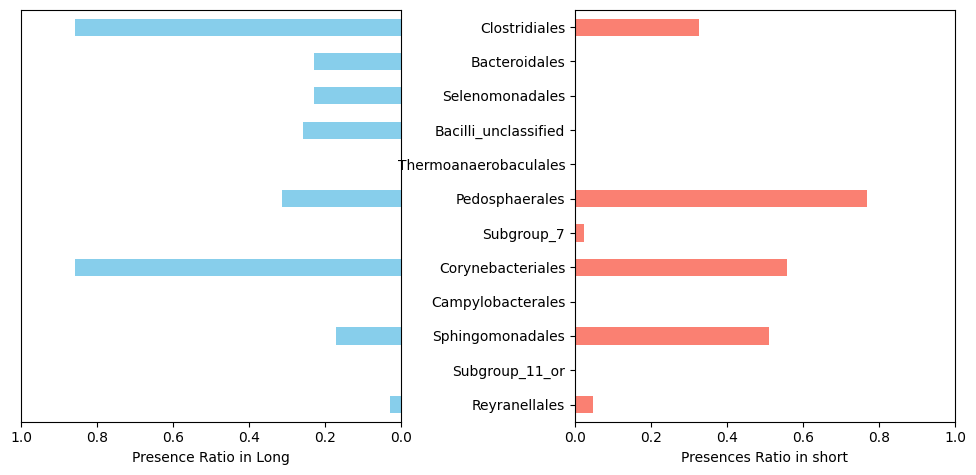

Analysis for class
Validation passed: Dimensions are correct.
Long= 35, short = 43
               OTU               presence_pos  presence_neg
0                    Clostridia    0.857143      0.325581  
1                       Bacilli    0.914286      0.441860  
2                 Negativicutes    0.228571      0.000000  
3           Thermoanaerobaculia    0.000000      0.000000  
4                    Subgroup_6    0.942857      1.000000  
5           Deltaproteobacteria    0.942857      0.976744  
6         Bacteria_unclassified    0.057143      0.279070  
7                    Nitrospira    0.000000      0.023256  
8                    Holophagae    0.000000      0.023256  
9                    Subgroup_5    0.000000      0.000000  
10  Blastocatellia_(Subgroup_4)    0.628571      0.860465  
11           Latescibacteria_cl    0.000000      0.069767  
12                  Subgroup_22    0.000000      0.000000  
13                        OLB14    0.000000      0.000000  
14              D

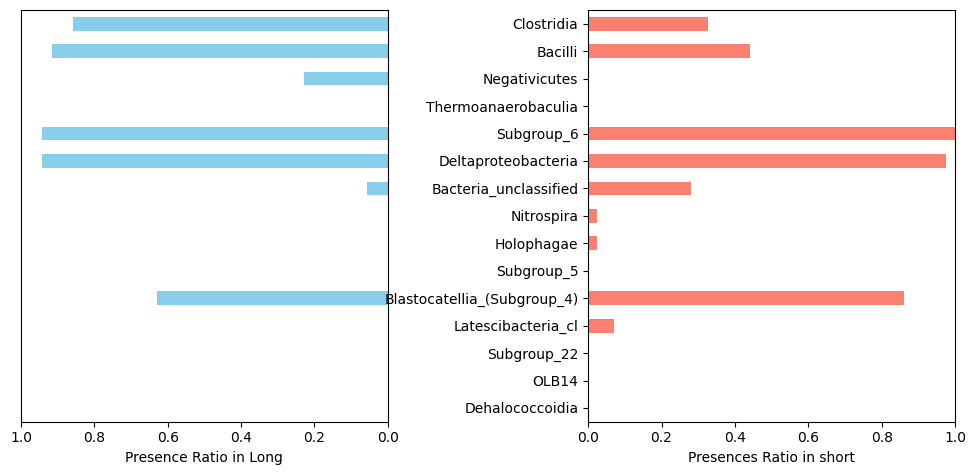

Validation passed: Dimensions are correct.
Long= 35, short = 43
               OTU               presence_pos  presence_neg
0                    Clostridia    0.857143      0.325581  
1           Alphaproteobacteria    1.000000      1.000000  
2           Deltaproteobacteria    0.942857      0.976744  
3                 Negativicutes    0.228571      0.000000  
4                    Subgroup_5    0.000000      0.000000  
5                    Holophagae    0.000000      0.023256  
6                 Fusobacteriia    0.057143      0.000000  
7                   Gitt-GS-136    0.000000      0.000000  
8              Gemmatimonadetes    0.514286      0.674419  
9               Campylobacteria    0.000000      0.000000  
10  Planctomycetes_unclassified    0.000000      0.000000  
11          Thermoanaerobaculia    0.000000      0.000000  
12               Ignavibacteria    0.000000      0.000000  
13              Melainabacteria    0.000000      0.000000  


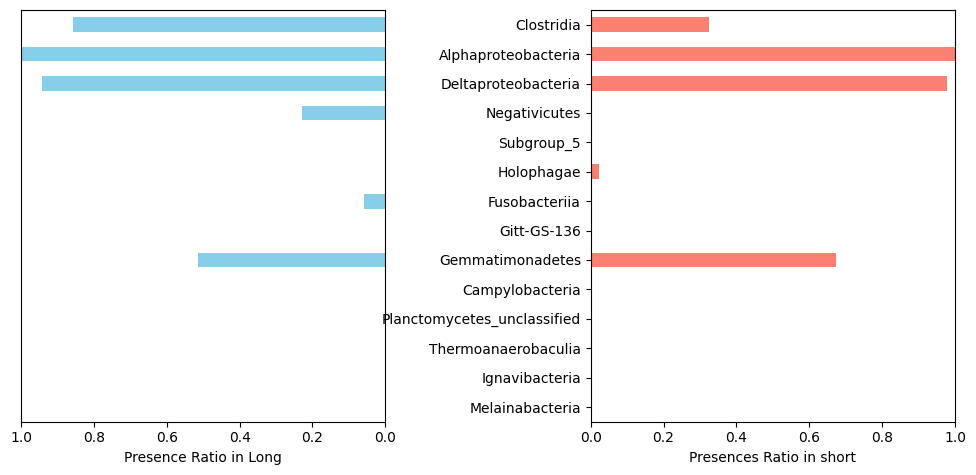

Validation passed: Dimensions are correct.
Long= 35, short = 43
               OTU               presence_pos  presence_neg
0                    Clostridia    0.857143      0.325581  
1                       Bacilli    0.914286      0.441860  
2                 Negativicutes    0.228571      0.000000  
3           Thermoanaerobaculia    0.000000      0.000000  
4           Deltaproteobacteria    0.942857      0.976744  
5                    Holophagae    0.000000      0.023256  
6                    Subgroup_5    0.000000      0.000000  
7   Blastocatellia_(Subgroup_4)    0.628571      0.860465  
8                         OLB14    0.000000      0.000000  
9               Dehalococcoidia    0.000000      0.000000  
10             Verrucomicrobiae    1.000000      1.000000  
11              Campylobacteria    0.000000      0.000000  
12               Ignavibacteria    0.000000      0.000000  
13              Latescibacteria    0.000000      0.000000  
14                 Anaerolineae    0

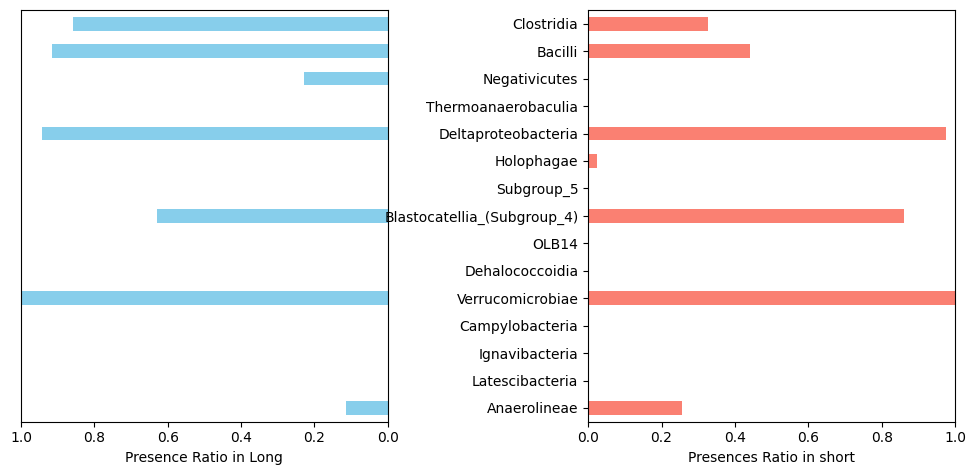

Analysis for phylum
Validation passed: Dimensions are correct.
Long= 35, short = 43
            OTU            presence_pos  presence_neg
0              Firmicutes    1.000000      0.558140  
1           Acidobacteria    0.971429      1.000000  
2   Bacteria_unclassified    0.057143      0.279070  
3             Nitrospirae    0.000000      0.023256  
4         Latescibacteria    0.000000      0.069767  
5           Elusimicrobia    0.000000      0.000000  
6         Verrucomicrobia    1.000000      1.000000  
7        Gemmatimonadetes    0.542857      0.697674  
8      Epsilonbacteraeota    0.000000      0.000000  
9         Armatimonadetes    0.000000      0.000000  
10         Planctomycetes    0.971429      1.000000  
11          Bacteroidetes    1.000000      1.000000  
12          Cyanobacteria    0.000000      0.000000  
13           Fusobacteria    0.057143      0.000000  
14        Patescibacteria    0.000000      0.116279  


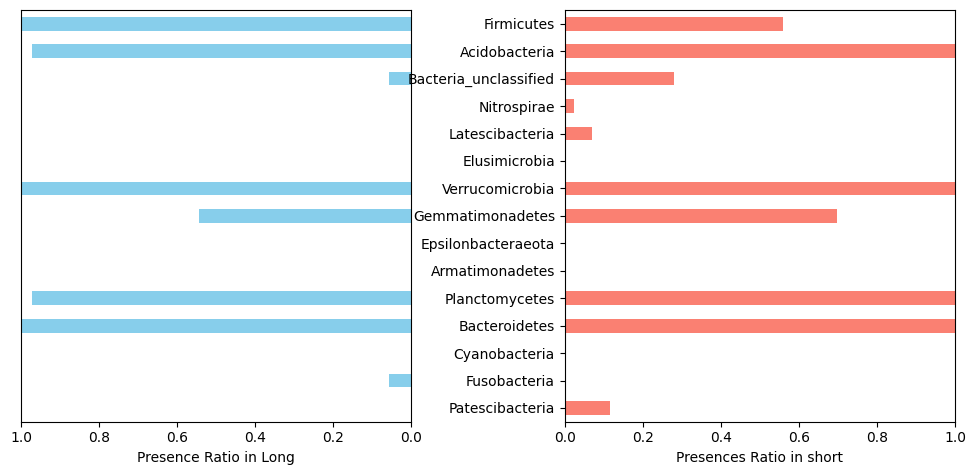

Validation passed: Dimensions are correct.
Long= 35, short = 43
          OTU          presence_pos  presence_neg
0       Acidobacteria    0.971429      1.000000  
1          Firmicutes    1.000000      0.558140  
2        Fusobacteria    0.057143      0.000000  
3    Gemmatimonadetes    0.542857      0.697674  
4  Epsilonbacteraeota    0.000000      0.000000  
5     Armatimonadetes    0.000000      0.000000  


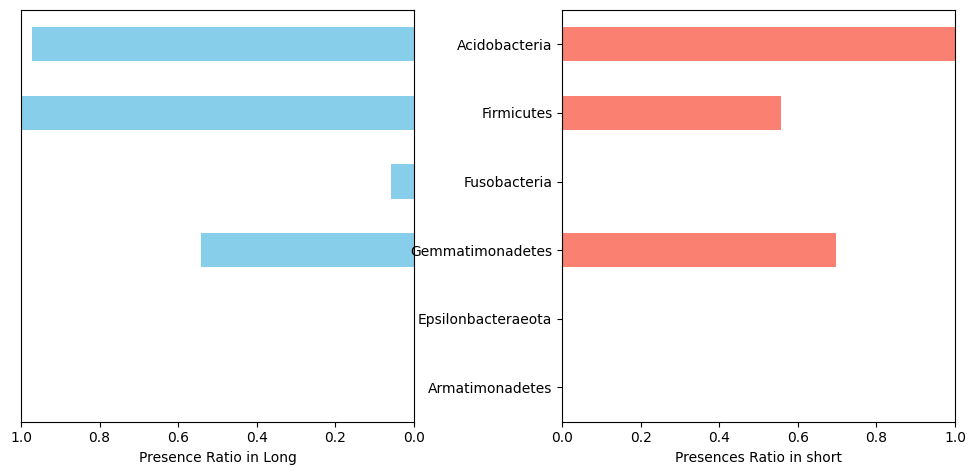

Validation passed: Dimensions are correct.
Long= 35, short = 43
          OTU          presence_pos  presence_neg
0          Firmicutes    1.000000      0.558140  
1       Acidobacteria    0.971429      1.000000  
2    Gemmatimonadetes    0.542857      0.697674  
3  Epsilonbacteraeota    0.000000      0.000000  
4     Armatimonadetes    0.000000      0.000000  
5        Fusobacteria    0.057143      0.000000  


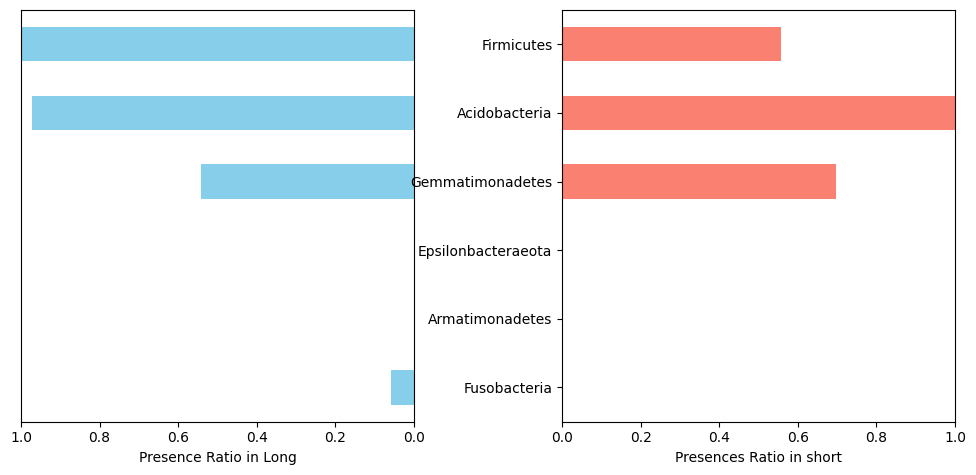

In [30]:
entries=15

for i, data0 in enumerate(data_4taxa):
    print(f"Analysis for {taxlabels[i]}")
    X_FS_15= X_FS_4taxa[i][:,:entries]
    selectedOTU_index_15=selectedOTU_index_4tax[i][:entries]
    selectedASVs_15 = col_names_4taxa[i][selectedOTU_index_15]
    FS.plotPresenseRatio(X_FS_15,targetLabel,selectedASVs_15,posLabel="LONG",posText="Long",negText="short")
    #FS.OTUviolin(X_FS_15,targetLabel,selectedASVs_15,y_max=0.3)

    M1 = min(entries,X_lasso_4taxa[i].shape[1])
    selectedLasso_index_15=xind_lasso_4taxa[i][:M1] # select the first M features, no ranking
    selectedlasso_15 = col_names_4taxa[i][selectedLasso_index_15]
    X_lasso_15 = data0[:,selectedLasso_index_15]
    FS.plotPresenseRatio(X_lasso_15,targetLabel,selectedlasso_15,posLabel="LONG",posText="Long",negText="short")
    #FS.OTUviolin(X_lasso_4taxa_15,targetLabel,selectedlasso_15,y_max=0.3)
    
    M2 = min(entries,X_FS_lasso_4taxa[i].shape[1])
    FS_Lasso_index_15=xind_FS_lasso_4taxa[i][:M2] # select the first M features, no ranking
    FS_lasso_15 = col_names_4taxa[i][FS_Lasso_index_15]
    X_FS_lasso_15 = data0[:,FS_Lasso_index_15]
    FS.plotPresenseRatio(X_FS_lasso_15,targetLabel,FS_lasso_15,posLabel="LONG",posText="Long",negText="short")
   

    

### Negative Gini Impurity
Gini Impurity is the probability of incorrectly classifying a randomly chosen element in the dataset if it were randomly labeled according to the class distribution in the dataset. It’s calculated as:

$G = 1- \sum_{i=1}^C p_i^2$

where C is the number of classes. (which means it can be used to measure for multiple level classification)

Here I will use the negative Gini Impurity to measure each OTU, if NG is large (1) which means the OTU only exist in one class, if NG value is small($1/c$) which means the OTU is evenly distributed among  the classes.

$NG = \sum_{i=1}^C p_i^2$

In [ ]:
np.unique(y, return_counts=True)

In [ ]:
# NG for selected OTU
NG_4tax = []
for i, data  in enumerate(data_4taxa):
    X_FS = data[:,selectedOTU_index_4tax[i]]
    X_lasso = data[:,xind_lasso_4taxa[i]]
    NG_selected = metric.Neg_GINI(X_FS,targetLabel)
    NG_Lasso = metric.Neg_GINI(X_lasso,targetLabel)
    print(NG_selected.shape)
    print(NG_Lasso.shape)
    NG_4tax.append([NG_selected,NG_Lasso])

In [ ]:
# compare the selected and non select by lasso
# Number of subplots
num_plots = len(data_4taxa)

# Create a figure with a grid of subplots
plt.figure(figsize=(4, 4 * num_plots))

# Loop through each index and create a subplot
for i in range(num_plots):
    plt.subplot(num_plots, 1, i + 1)  # (nrows, ncols, index)
    plt.boxplot([NG_4tax[i][0], NG_4tax[i][1]], tick_labels=['SelectMicro', 'Lasso'])
    plt.title(f'NG results of the selected OTU by SelectMicro vs. Lasso - {taxlabels[i]}')
    plt.ylabel('NG')
    plt.grid(axis='y')
# Adjust layout
plt.tight_layout()  # Adjusts the subplots to fit into the figure area.
plt.show()  # Show all plots at once

#### Analysis of the top features

In [ ]:
for i, label in enumerate(col_names_sig_sorted_4taxa):
    print(taxlabels[i])
    print(label)

Compare the result of paper:



for Phylum, among the 19 16S features selected by the paper, 13 are selected here (we select 15 in total)




<b>'Clostridia'</b>, 'Bacilli', 'Negativicutes', 'Thermoanaerobaculia', 'Subgroup_6', 'Deltaproteobacteria', 'Bacteria_unclassified', 'Nitrospira', 'Holophagae', 'Subgroup_5', 'Blastocatellia_(Subgroup_4)', 'Latescibacteria_cl', 'Subgroup_22', 'OLB14', 'Dehalococcoidia', 'Verrucomicrobiae', 'OM190', 'Campylobacteria', 'JG30-KF-CM66', 'TK10', 'Ignavibacteria', 'Parcubacteria', 'Phycisphaerae', 'Fimbriimonadia', 'Gemmatimonadetes', 'Actinobacteria', 'Latescibacteria', 'Anaerolineae', 'Melainabacteria', 'Chthonomonadetes', 'Proteobacteria_unclassified', 'Pla4_lineage', 'Bacteroidia', 'Elusimicrobia', 'Acidobacteriia', 'Fusobacteriia', 'Lineage_IIa', 'Subgroup_17', 'Subgroup_11', 'Erysipelotrichia', 'Lineage_IIb', 'Chloroflexi_unclassified', 'S0134_terrestrial_group', 'Ktedonobacteria'


<b>'Firmicutes', 'Acidobacteria'</b>, <b>'Bacteria_unclassified'</b>, <b>'Nitrospirae'</b>, '<b>Latescibacteria'</b>, '<b>Elusimicrobia'</b>, <b>'Verrucomicrobia'</b>, <b>'Gemmatimonadetes'</b>, <b>'Epsilonbacteraeota'</b>, '<b>Armatimonadetes'</b>, 'Planctomycetes', '<b>Bacteroidetes'</b>, '<b>Cyanobacteria'</b>, 'Fusobacteria', 'Patescibacteria'


Change threshold to 1%

In [ ]:
data_4taxa_1 = []
col_names_4taxa_1 = []
for df in bact_noenv_df_list:
    data = df.drop(df.columns[0], axis=1)
    cols_name = data.columns.tolist()
    data = data.values
    data =FS.relative_abundance(data,cutOff=0.01)
    data_4taxa_1.append(data)
    col_names_4taxa_1.append(cols_name)

In [ ]:
weights_4taxa_1 = []
for df in data_4taxa_1:
    print(np.shape(df))
    weights=FS.OTU_H_Score_fun(df,targetLabel)
    weights_4taxa_1.append(weights)
    

In [ ]:
max(weights_4taxa_1[3])

In [ ]:
selectedOTU_index_4tax_1 = []
eps_4tax_1 = []

for weight in weights_4taxa_1:
    selectedOTU_index, eps=FS.indice_H_unisig(weight,targetLabel)
    print(eps)
    selectedOTU_index_4tax_1.append(selectedOTU_index)
    eps_4tax_1.append(eps)

In [ ]:
weights_sig_sorted_4taxa_1 = []
col_names_sig_sorted_4taxa_1 = []
for i in range(len(weights_4taxa_1)):
    weights_sig_sorted = weights_4taxa_1[i][selectedOTU_index_4tax_1[i]]
    col_names_sig_sorted = [col_names_4taxa_1[i][j] for j in selectedOTU_index_4tax_1[i]]
    weights_sig_sorted_4taxa_1.append(weights_sig_sorted)
    col_names_sig_sorted_4taxa_1.append(col_names_sig_sorted)

In [ ]:
for i, label in enumerate(col_names_sig_sorted_4taxa_1):
    print(taxlabels[i])
    print(label)

In [ ]:
weights_sig_sorted_4taxa_1[3]

<b>'Firmicutes', 'Acidobacteria', 'Verrucomicrobia', 'Gemmatimonadetes', 'Bacteria_unclassified', 'Planctomycetes', 'Bacteroidetes',</b> 'Entotheonellaeota', 'Patescibacteria'

Some of the features are not selected in the ITS+16S data, this is because the relative abundance is different in these 2 analysis (since the dataset will do normalization based on each sample)

Cpmpared with the low threshold (which will have more features?):

<b>'Firmicutes', 'Acidobacteria'</b>, <b>'Bacteria_unclassified'</b>, <b>'Nitrospirae'</b>, '<b>Latescibacteria'</b>, '<b>Elusimicrobia'</b>, <b>'Verrucomicrobia'</b>, <b>'Gemmatimonadetes'</b>, <b>'Epsilonbacteraeota'</b>, '<b>Armatimonadetes'</b>, 'Planctomycetes', '<b>Bacteroidetes'</b>, '<b>Cyanobacteria'</b>, 'Fusobacteria', 'Patescibacteria'


There is one feature that is selected using a strict threshold:

In [ ]:
indice1 = [col_names_4taxa[3].index('Entotheonellaeota')]
FS.OTU_H_Score_fun(data_4taxa[3][:,indice1],targetLabel)

In [ ]:
indice2 = [col_names_4taxa_1[3].index('Entotheonellaeota')]
FS.OTU_H_Score_fun(data_4taxa_1[3][:,indice2],targetLabel)

In [ ]:
#print(np.column_stack((data_4taxa[3][:,indice1],data_4taxa_1[3][:,indice2],targetLabel)))

In [ ]:
data_subset_4taxa_1 = []
X_lasso_4taxa_1 = []
xind_lasso_4taxa_1 = []
for i, data  in enumerate(data_4taxa_1):
    X_lasso,xind_lasso = RunML_continue.LassoFeatureSelection(data,targetLabel)
    X_lasso_4taxa_1.append(X_lasso_4taxa)
    xind_lasso_4taxa_1.append(xind_lasso)
    data_subset = {"AllFeatures":data, 
               "SelectMicro": data[:,selectedOTU_index_4tax[i]],
               "Lasso":X_lasso,
               "Random":data
              }
    data_subset_4taxa_1.append(data_subset)
    


In [ ]:
NG_4tax_1 = []
for i, data  in enumerate(data_4taxa_1):
    X_FS = data[:,selectedOTU_index_4tax_1[i]]
    X_lasso = data[:,xind_lasso_4taxa_1[i]]
    NG_selected = metric.Neg_GINI(X_FS,y)
    NG_Lasso = metric.Neg_GINI(X_lasso,y)
    print(NG_selected.shape)
    print(NG_Lasso.shape)
    NG_4tax_1.append([NG_selected,NG_Lasso])

In [ ]:
# compare the selected and non select by lasso
# Number of subplots
num_plots = len(data_4taxa_1)

# Create a figure with a grid of subplots
plt.figure(figsize=(4, 4 * num_plots))

# Loop through each index and create a subplot
for i in range(num_plots):
    plt.subplot(num_plots, 1, i + 1)  # (nrows, ncols, index)
    plt.boxplot([NG_4tax_1[i][0], NG_4tax_1[i][1]], tick_labels=['SelectMicro', 'Lasso'])
    plt.title(f'NG results of the selected OTU by SelectMicro vs. Lasso - {taxlabels[i]}')
    plt.ylabel('NG')
    plt.grid(axis='y')
# Adjust layout
plt.tight_layout()  # Adjusts the subplots to fit into the figure area.
plt.show()  # Show all plots at once